In [37]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [38]:
df = sns.load_dataset("mpg")

X_train, y_train = df[~df["horsepower"].isna()][["displacement", "acceleration"]], df[~df["horsepower"].isna()]["horsepower"]
X_pred = df[df["horsepower"].isna()][["displacement", "acceleration"]]

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_pred)
y_pred = np.round(y_pred)
df.loc[X_pred.index, "horsepower"] = y_pred
df = pd.get_dummies(df.drop("name", axis = 1), columns = ["origin"])
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin_europe,origin_japan,origin_usa
0,18.0,8,307.0,130.0,3504,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449,10.5,70,0,0,1


In [39]:
X, y = df.drop(["mpg"], axis = 1).values, df["mpg"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

In [40]:
#scaler = StandardScaler()
scaler = MinMaxScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)
scaled_X_test = scaler.transform(X_test)

In [41]:
class VectorRegressor:
    def __init__(self, n = 100, hidden_layers = False, activation = "sigmoid", random_state = None, verbose = 0):

        self.n = n // 2 * 2
        self.nets = []
        self.best_net = -1
        self.best_result = None
        self.validation_loss_history = []
        self.training_loss_history = []
        self.mutation_sigma = 0

        if activation == "sigmoid":
            self.activation_function = lambda x: 1 / (1 + np.exp(-x))
        elif activation == "relu":
            self.activation_function = lambda x: np.maximum(0, x)
        elif activation == "leaky_relu":
            self.activation_function = lambda x: np.maximum(0.1 * x, x)
        
        if hidden_layers:
            self.layers = hidden_layers + [1]
        else:
            self.layers = [1]
        
        if random_state != None:
            np.random.seed(random_state)

        self.verbose = verbose

    
    def fit(self, X_train, y_train, epochs = 100, validation_data = False, verbose = 0):
        X_train = np.c_[np.ones(X_train.shape[0]), X_train]

        if validation_data:
            X_val, y_val = validation_data

        self.layers = [X_train.shape[1]] + self.layers

        self.y_preds = np.zeros((self.n, y_train.shape[0]))
        self.nets_loss = np.zeros(self.n)
        self.sorted_indecies = np.zeros(self.n)

        self.weights = []

        for i in range(len(self.layers) - 1):
            self.weights += [np.random.uniform(-3, 3, (self.n, self.layers[i], self.layers[i + 1]))]

        for epoch in range(epochs):
            forward_pass = X_train.T
            
            for j in range(0, len(self.layers) - 2):
                forward_pass = self.activation_function(self.weights[j].transpose(0, 2, 1) @ forward_pass)

            forward_pass = self.weights[-1].transpose(0, 2, 1) @ forward_pass
            self.y_preds = forward_pass.reshape(self.n, -1)

            self.nets_loss = np.mean(np.abs(self.y_preds - y_train), axis = 1)

            self.sorted_indecies = np.argsort(self.nets_loss)

            self.mutation_sigma = 0.1 + 5 * 1 / math.exp(epoch / ((epochs + 1) / (100 * math.log10(epochs + 1))))

            for j in range(0, len(self.layers) - 1):
                self.weights[j][self.sorted_indecies[50::2]] = np.mean((self.weights[j][self.sorted_indecies[:50:2]], self.weights[j][self.sorted_indecies[1:51:2]]), axis = 0) + np.random.normal(0, self.mutation_sigma, (self.n // 4, self.layers[j], self.layers[j + 1]))
                self.weights[j][self.sorted_indecies[51::2]] = np.mean((self.weights[j][self.sorted_indecies[:50:2]], self.weights[j][self.sorted_indecies[1:51:2]]), axis = 0) + np.random.normal(0, self.mutation_sigma, (self.n // 4, self.layers[j], self.layers[j + 1]))

            if self.best_net != self.sorted_indecies[0]:
                self.best_net = self.sorted_indecies[0]
                self.training_loss_history += [self.nets_loss[self.best_net]]
                
                if validation_data:
                    self.validation_loss_history += [np.mean(np.abs(y_val - self.predict(X_val)))]
                    if verbose == 1:
                        print(f"Epoch {epoch} - loss: {self.training_loss_history[-1]} - val_loss: {self.validation_loss_history[-1]}")
                else:
                    if verbose == 1:
                        pass
                        print(f"Epoch {epoch} - loss: {self.training_loss_history[-1]}")


    def predict(self, X):
        X = np.c_[np.ones(X.shape[0]), X]

        forward_pass = X.T
        for j in range(0, len(self.layers) - 2):
            forward_pass = self.activation_function(self.weights[j][self.best_net].T @ forward_pass)

        forward_pass = self.weights[-1][self.best_net].T @ forward_pass
        return forward_pass.reshape(-1)


In [57]:
regressor = VectorRegressor(n = 100, hidden_layers = [4], activation = "sigmoid", random_state = 42)
regressor.fit(scaled_X_train, y_train, epochs = 1000, validation_data = (scaled_X_val, y_val), verbose = 1)

Epoch 0 - loss: 19.5278995791053 - val_loss: 17.85078778100287
Epoch 1 - loss: 8.53922295450218 - val_loss: 7.749019880166648
Epoch 2 - loss: 8.105124356386156 - val_loss: 7.355032976950125
Epoch 3 - loss: 7.6355299064000235 - val_loss: 6.825480188004034
Epoch 4 - loss: 7.248511940427422 - val_loss: 6.119392352756424
Epoch 5 - loss: 6.595255763238522 - val_loss: 6.216913137674284
Epoch 6 - loss: 5.962352925178464 - val_loss: 5.909876561064507
Epoch 7 - loss: 5.705672637323295 - val_loss: 5.2959872859993125
Epoch 8 - loss: 5.08855254840753 - val_loss: 4.811643063551418
Epoch 9 - loss: 4.9575643088985855 - val_loss: 4.705323341573136
Epoch 10 - loss: 4.866797189808337 - val_loss: 4.212939746113839
Epoch 11 - loss: 4.619727559057142 - val_loss: 4.069375569182223
Epoch 12 - loss: 4.597776310430236 - val_loss: 4.0540780530942415
Epoch 13 - loss: 4.378934033595037 - val_loss: 3.696208166631709
Epoch 14 - loss: 4.326582479741205 - val_loss: 3.8482042155777463
Epoch 17 - loss: 4.15882449868596

Loss on test data: 1.6363038572394935


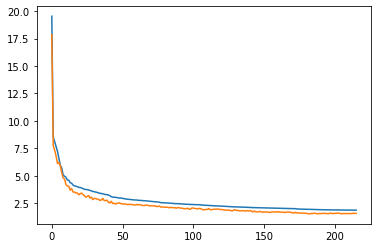

In [58]:
y_pred = regressor.predict(scaled_X_test)
print(f"Loss on test data: {mean_absolute_error(y_test, y_pred)}")

fig, ax = plt.subplots(1, 1)

ax.plot(regressor.training_loss_history)
ax.plot(regressor.validation_loss_history)

plt.show()

In [33]:
regressor.training_loss_history


[12.540278541304668,
 11.31345956102197,
 9.29034471983734,
 9.11636371228251,
 7.640114282614082,
 6.505026080976028,
 6.3570673091791425,
 5.51358221946053,
 5.33594391669974,
 4.986325216071821,
 4.9410857045291685,
 4.790030202248466,
 4.749067443819467,
 3.8972344058192774,
 3.6925757484190127,
 3.68303803091034,
 3.5431420061352927,
 3.366475849355694,
 3.079655574779169,
 2.9474978762440234,
 2.901172241620006,
 2.5159325174712728,
 2.4443395138624786,
 2.430107207574906,
 2.418759455752082,
 2.414501076460732,
 2.380818836380886,
 2.3396561542751626,
 2.323674960444538,
 2.3072072124522407,
 2.3064289079221982,
 2.2739165934330403,
 2.218879978307752,
 2.218539046926688,
 2.21300746455699,
 2.201819536484139,
 2.1997369508970803,
 2.182749551527073,
 2.181427662245525,
 2.166911377581538,
 2.1645932766932146,
 2.1549412618691726,
 2.1499137750488306,
 2.14982278419821,
 2.1493195963487417,
 2.149128094058345,
 2.1337333113412806,
 2.126550673726339,
 2.1244119746258043,
 2.1192

In [26]:
y_pred = vregressor.predict(scaled_X_test)

In [16]:
y_pred

array([29.64140437, 34.21617117, 24.74893805, 38.62679494, 15.876758  ,
       20.02510414, 13.46302104, 34.90722375, 13.29632817, 23.60215502,
       26.86724428, 23.19228495, 35.32786318, 12.72546595, 27.18078347,
       34.17316901, 18.61793492, 33.68498309, 11.87646859, 24.63018934,
       18.42963081, 18.84493869, 25.39409425, 22.80014085, 34.74881644,
       22.47990386, 21.1984451 , 27.10008261, 31.60438038, 26.05328812,
       17.96848593, 18.22051233, 11.42318815, 20.31168452, 11.55482496,
       37.67098392, 23.50907463, 45.18838465, 21.93169879, 14.97971544])

In [27]:
mean_absolute_error(y_test, y_pred)

1.6244880201432412

In [361]:
activation_function = np.vectorize(lambda x: 1 / (1 + math.exp(-x)))

w = [np.array([[[0, 3],[2, 0]],[[1, 3],[9, 7]],[[5, 8],[3, 3]]]),
    np.array([[[2],[6]],[[0],[4]],[[6],[9]]])]
#w1 = np.array([[[0, 3],[2, 0]],[[1, 3],[9, 7]],[[5, 8],[3, 3]]])
#w2 = np.array([[[2],[6]],[[0],[4]],[[6],[9]]])

np.random.seed(42)

B = np.array([  [8, 0],
                [9, 2],
                [6, 3]])

pred = []

for i in range(3):
    forward_pass = B.T
    forward_pass = activation_function(w[0][i].T @ forward_pass)

    forward_pass = w[1][i].T @ forward_pass

    pred.append(forward_pass.reshape(-1))



In [363]:
pred

[array([7.        , 7.96402758, 7.99505466]),
 array([4., 4., 4.]),
 array([15., 15., 15.])]

In [364]:


forward_pass = B.T
forward_pass = activation_function(w[0].transpose(0, 2, 1) @ forward_pass)
forward_pass = w[1].transpose(0, 2, 1) @ forward_pass
pred = forward_pass.reshape(3, 3)


In [365]:
pred.reshape(3, 3)

array([[ 7.        ,  7.96402758,  7.99505466],
       [ 4.        ,  4.        ,  4.        ],
       [15.        , 15.        , 15.        ]])

In [309]:
w2.shape

(3, 2, 1)

In [279]:
pred

[array([48, 58, 42, 72, 93, 72]),
 array([56, 73, 57, 16, 26, 24]),
 array([32, 54, 51,  0, 10, 15])]

In [282]:
np.random.randint(0, 10, (2, 2, (1, 1)), dtype = "object")

TypeError: Unsupported dtype dtype('O') for randint